## Transfer Learning for Skin Cancer Classification

Skin Cancer is the most common cancer in the world.  In the United States alone, we find 5.4 million new cases every year.  20% of Americans will eventually get Skin Cancer, in most cases Benin Cancer.  

We have 76,000 Melanoma's in the United States each year.

Melanoma is the deadiest form of skin cancer, as it's responsible for over 10,000 deaths per year.

To put it in perspective, there are 40,000 deaths each year from car accidents.

The costs per year on the United States is $8.1 billion on treatment.

The 5 year survival rate for stage 4 Melanoma is 15% to 20 %

The 5 year survival rate for stage 0 Melanoma is 99% to 100%

![https://puu.sh/B1KYH/2dc7f109d9.png](https://puu.sh/B1KYH/2dc7f109d9.png)

![https://puu.sh/B1KZm/49f3ad8222.png](https://puu.sh/B1KZm/49f3ad8222.png)

Due to the survival rate of the different stages of Melanoma, it's clear that it's paramount that early detection is done to migigate the effects of Skin Cancer.

Sometimes it's hard to classify because a patient could have lots of moles.  To find the one that's malignant it's has become a hard problem to solve.

![https://puu.sh/B1L7J/c1d1c5d118.png](https://puu.sh/B1L7J/c1d1c5d118.png)

Melanoma originates in the cells of the skin that make pigment, called melanocytes.

When diagnosed early, melanoma is easily cured by simple outpatient surgical excision.

If permitted to progress, melanomas that are less than an ½ inch across on the surface of the skin can spread (metastasize) and lead to death.

Discriminating melanoma from benign moles can be challenging- especially in patient with lots of moles and ‘atypical’ moles.
[image from pptx]

![https://puu.sh/B1L9k/678b5698ab.png](https://puu.sh/B1L9k/678b5698ab.png)

Dermoscopy
As pigmented lesions occurring on the surface of the skin, melanoma is amenable to early detection by expert visual inspection. It is also amenable to automated detection with image analysis. Given the widespread availability of high-resolution cameras, algorithms that can improve our ability to screen and detect troublesome lesions can be of great value. As a result, many centers have begun their own research efforts on automated analysis. However, a centralized, coordinated, and comparative effort across institutions has yet to be implemented.

Dermoscopy is an imaging technique that eliminates the surface reflection of skin. By removing surface reflection, visualization of deeper levels of skin is enhanced. Prior research has shown that when used by expert dermatologists, dermoscopy provides improved diagnostic accuracy, in comparison to standard photography. As inexpensive consumer dermatoscope attachments for smart phones are beginning to reach the market, the opportunity for automated dermoscopic assessment algorithms to positively influence patient care increases.

We are going to use a dataset of images using Dermospcopy to diagnose cancer better than current 

We will design an algorithm that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, our algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, participants were tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). 

Based on work from [https://arxiv.org/pdf/1710.05006.pdf](https://arxiv.org/pdf/1710.05006.pdf)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import keras 
from keras.utils import np_utils
from glob import glob

## Import Dataset

In [5]:
def load_dataset(path):
    data = load_files(path, shuffle=True)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [6]:
train_files, train_labels = load_dataset('data/train')
valid_files, valid_labels = load_dataset('data/valid')

In [7]:
def load_dataset_no_shuffle(path):
    data = load_files(path, shuffle=False)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [8]:
test_files , test_labels = load_dataset_no_shuffle('data/test')

In [9]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(path):
    
    img = image.load_img(path, target_size = (224,224))
    x= image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(paths)]
    return np.vstack(list_of_tensors)

In [10]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 600/600 [08:58<00:00,  4.12it/s]


## Let's first train on Inception

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [12]:
from keras.applications.inception_v3 import InceptionV3

model_inception = InceptionV3(weights = 'imagenet', include_top = False)

In [13]:
train_features_inception = model_inception.predict(train_tensors, verbose=1)
valid_features_inception = model_inception.predict(valid_tensors, verbose=1)
test_features_inception = model_inception.predict(test_tensors, verbose=1)

600/600 [==============================] - 135s 226ms/step


In [14]:

model = Sequential()

model.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation ='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
__________

In [15]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [16]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(save_best_only = True, verbose =1, 
                             filepath = 'saved_models/weights.best.from_inception.hdf5')

model.fit(train_features_inception, 
          train_labels, 
          epochs=25, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/25
1984/2000 [============================>.] - ETA: 0s - loss: 0.8840 - acc: 0.6613  

In [17]:
model.load_weights('saved_models/weights.best.from_inception.hdf5')

In [18]:
test_predictions = np.argmax(model.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 68.5000%


In [19]:
print(np.argmax(test_labels[25]))
print(test_predictions[25])

0
0


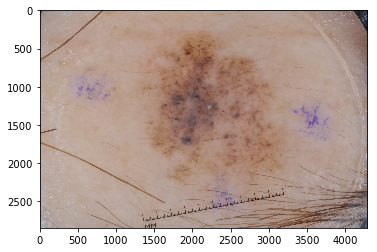

In [20]:
import cv2
img = cv2.imread(test_files[25])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [21]:
test_predictions = model.predict(test_features_inception)
test_predictions_task1 = test_predictions[:,0]
test_predictions_task2 = test_predictions[:,2]

In [22]:
submission_inception = pd.DataFrame({'Id':test_files, 'task_1':test_predictions_task1,'task_2':test_predictions_task2})
pd.DataFrame.to_csv(submission_inception, 'submission.csv', index=False)

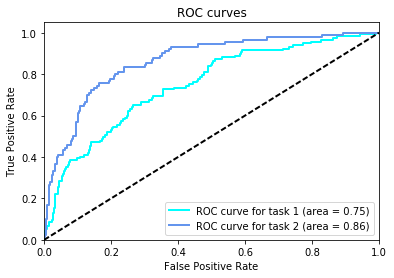

Category 1 Score: 0.748
Category 2 Score: 0.862
Category 3 Score: 0.805


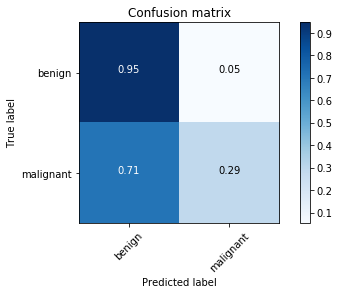

In [23]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

if __name__ == "__main__":

    preds_path = sys.argv[1]
    
    thresh = 0.5

    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])

    # get model predictions for test dataset
    y_pred = pd.read_csv('submission.csv')
    y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

    # plot ROC curves and print scores
    plot_roc_auc(y_true, y_pred)
    # plot confusion matrix
    classes = ['benign', 'malignant']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)


In [32]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

model_inception_resnet = InceptionResNetV2(weights = 'imagenet', include_top = False)

In [33]:
model_inception_resnet = Sequential()

model_inception_resnet.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(1024, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(512, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(128, activation = 'relu'))
model_inception_resnet.add(Dropout(0.2))
model_inception_resnet.add(Dense(3, activation ='softmax'))


model_inception_resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               65664     
__________

In [35]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model_inception_resnet.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [37]:
from keras.callbacks import ModelCheckpoint

checkpoint_inception = ModelCheckpoint(
    save_best_only = True, 
    verbose = 1, 
    filepath = 'saved_models/weights.best.from_inception_resnet_v2.hdf5')

model_inception_resnet.fit(train_features_inception, 
          train_labels, 
          epochs=35, 
          batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks=[checkpoint_inception], verbose=1
         )

Train on 2000 samples, validate on 150 samples
Epoch 1/35
1984/2000 [============================>.] - ETA: 0s - loss: 0.2790 - acc: 0.8911

In [38]:
model_inception_resnet.load_weights('saved_models/weights.best.from_inception_resnet_v2.hdf5')

In [39]:
test_predictions = np.argmax(model_inception_resnet.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 70.0000%


In [40]:
submission_inception_resnet = pd.DataFrame({'Id':test_files, 'task_1':test_predictions_task1,'task_2':test_predictions_task2})
pd.DataFrame.to_csv(submission_inception_resnet, 'submission.csv', index=False)

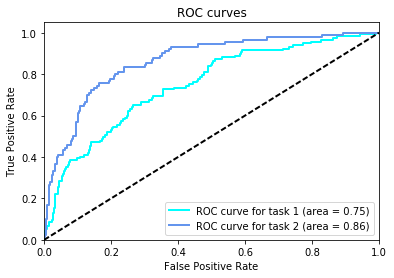

Category 1 Score: 0.748
Category 2 Score: 0.862
Category 3 Score: 0.805


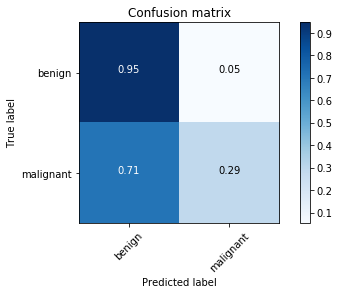

In [41]:
preds_path = sys.argv[1]
    
thresh = 0.5

# get ground truth labels for test dataset
truth = pd.read_csv('ground_truth.csv')
y_true = truth.as_matrix(columns=["task_1", "task_2"])

# get model predictions for test dataset
y_pred = pd.read_csv('submission.csv')
y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

# plot ROC curves and print scores
plot_roc_auc(y_true, y_pred)
# plot confusion matrix
classes = ['benign', 'malignant']
plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)
